# Overwrite Portal Content with ArcGIS Pro Projects

This Notebook will use a [map](http://pro.arcgis.com/en/pro-app/help/mapping/map-authoring/maps.htm) in your [ArcGIS Pro Project](http://pro.arcgis.com/en/pro-app/get-started/overview-of-arcgis-pro.htm) to update [Items](http://doc.arcgis.com/en/arcgis-online/manage-data/add-items.htm) in your ArcGIS Online/Enterprise (collectivly called portal). If you want to [use a CSV file to update your Feature Layer](https://github.com/Esri/arcgis-python-api/blob/master/samples/05_content_publishers/overwriting_feature_layers.ipynb) in your portal check out [Esri's GitHub Python API page](https://github.com/Esri/arcgis-python-api)



#### Import Libraries
1. It all starts with the [arcgis.gis module](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#module-arcgis.gis) which is the most important and provides the entry point into the GIS.

2. The [getpass module](https://docs.python.org/3.7/library/getpass.html) provides two functions
    * getpass() prompts for a password
    * getuser() returns login name. This could be useful if your portal is federated with Active Directory
3. The [display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html?highlight=display#IPython.display.display) in IPython is similar to print() but does more in Jupyter

In [1]:
import arcpy
import os
import sys

from arcgis.gis import GIS
from arcgis import features
from getpass import getpass
#from getpass import getuser
from IPython.display import display

Now we get the ```input()``` from the user to set the ArcGIS Pro Project path then find the file extension of that ArcGIS Pro Project to use later.

The next cell uses Python 3 [formatted string literal](https://docs.python.org/3/reference/lexical_analysis.html#f-strings), or f-string. By the way [this is an excellent tutorial on using f-strings](https://realpython.com/python-f-strings/)
    

In [2]:
#TODO use python pathlib
prjPath = (os.environ['USERPROFILE']+'\Documents\ArcGIS\Projects\\')
changePath = input(f'Use default ArcGIS Project Path? {prjPath}? [y or n]')
if changePath.upper() in "NO":
    prjPath = input('Enter new path ')
    os.chdir(prjPath)
for project in os.listdir(prjPath):
    usePrj = input(f'Use project {project} [y or n]')
    if usePrj.upper() in "YES":
        prjPath = os.path.join(prjPath,project)
        break
for root, dirs, files in os.walk(prjPath):
    for file in files:
        if file.endswith(".aprx"):
            aprx = os.path.join(root, file)
            print(f'Using {aprx}')
arcpy.env.workspace = prjPath
arcpy.env.overwriteOutput = True

Use default ArcGIS Project Path? C:\Users\friendde\Documents\ArcGIS\Projects\? [y or n]y
Use project AlpineAnalysis [y or n]n
Use project AlpineAuditProduction [y or n]n
Use project AlpineUpdates [y or n]n
Use project Alpine_ATT [y or n]n
Use project Alpine_Cox [y or n]n
Use project AVL [y or n]n
Use project ElectricServiceAreas [y or n]n
Use project GGCityLights [y or n]n
Use project GRUComAddresses [y or n]n
Use project Index [y or n]n
Use project LED Change Out [y or n]y
Using C:\Users\friendde\Documents\ArcGIS\Projects\LED Change Out\LED Change Out.aprx


Now we [get the active portal](http://pro.arcgis.com/en/pro-app/arcpy/functions/getactiveportalurl.htm) and instantiate the [GIS](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#gis). The [GetPortalDescription()](http://pro.arcgis.com/en/pro-app/arcpy/functions/getportaldescription.htm) returns a dictionary containing portal information.

TODO switching active portal fails

In [3]:
response = input(f'Do you want to use the active portal? {(arcpy.GetActivePortalURL())} [y or n]')
if response.upper() in "YES":
    username=input("Enter User Name")
    gis = GIS(arcpy.GetActivePortalURL(), username, password=(getpass()))
else:
    portalURL=input("Enter Portal Address")
    username=input("Enter User Name")
    gis = GIS(portalURL, username, password=getpass())
portal_desc = arcpy.GetPortalDescription()
print(f'Portal Name - {portal_desc["portalName"]}\nConnected to {portal_desc["name"]} as user {username}')

Do you want to use the active portal? https://gru.maps.arcgis.com/ [y or n]y
Enter User Namearcgiswebservices
········
Portal Name - ArcGIS Online
Connected to Gainesville Regional Utilities - Gainesville, FL as user arcgiswebservices


Using [gis.content.search()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.ContentManager.search) we are going to find all Groups and [item_types](https://developers.arcgis.com/rest/users-groups-and-items/items-and-item-types.htm) (that are Feature Layers) owned by connected user.

In [4]:
# search for all Groups owned by connected user
sourceGroups = gis.groups.search(query=f'owner:{username}')
sourceGroups

[<Group title:"Chief Officers" owner:arcgiswebservices>,
 <Group title:"Conservation Services" owner:arcgiswebservices>,
 <Group title:"Customer Operations" owner:arcgiswebservices>,
 <Group title:"Electric Transmission and Distribution" owner:arcgiswebservices>,
 <Group title:"Energy Delivery" owner:arcgiswebservices>,
 <Group title:"Energy Delivery Engineering" owner:arcgiswebservices>,
 <Group title:"Energy Delivery WARM" owner:arcgiswebservices>,
 <Group title:"GeoConX" owner:arcgiswebservices>,
 <Group title:"GRU to Alachua County" owner:arcgiswebservices>,
 <Group title:"GRU to Alpine Communication" owner:arcgiswebservices>,
 <Group title:"GRU to Community Redevelopment Agency" owner:arcgiswebservices>,
 <Group title:"GRU to Department of Doing" owner:arcgiswebservices>,
 <Group title:"GRU to Department of Technology" owner:arcgiswebservices>,
 <Group title:"GRU to Gainesville Fire Rescue" owner:arcgiswebservices>,
 <Group title:"GRU to Gainesville Police Department" owner:arcgis

In [5]:
# search and list all items owned by connected user
query=f'owner:{username}'
itemType="Feature Layer"
sortField="title"
sortOrder="asc"
# default max__items is 10
maxItems=100
searchResult = gis.content.search(query,itemType,sortField,sortOrder,maxItems)
searchResult


[<Item title:"1c69d98e19474201859acb1003363bcd" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"AllPoles" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"CityCountyRental_WFL1" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"CW_BaseMap" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"EDWorkSiteCondition" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"ElectricDamageAssessment" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"ElectricDamageAssessmentPie" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"Find_Clusters_for_eAll_Assessments" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"GG_Lights" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"GRUBaseMap" type:Feature Layer Collection owner:arcgiswebservices>,
 <Item title:"GRUComFiber" type:Feature Layer Collection owner:arcgiswebservices>,
 <I

<Item title:"1c69d98e19474201859acb1003363bcd" type:Feature Layer Collection owner:arcgiswebservices>
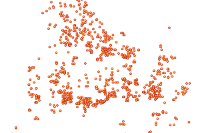

Update 1c69d98e19474201859acb1003363bcd [Y,N]n


<Item title:"AllPoles" type:Feature Layer Collection owner:arcgiswebservices>
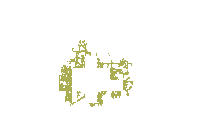

Update AllPoles [Y,N]n


<Item title:"CityCountyRental_WFL1" type:Feature Layer Collection owner:arcgiswebservices>
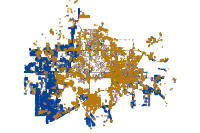

Update CityCountyRental_WFL1 [Y,N]y


In [6]:
for i in range(len(searchResult)):
    display(searchResult[i])
    updateResult = input(f'Update {(searchResult[i].title)} [Y,N]')
    if updateResult.upper() in "YES":
        sdItem = searchResult[i]
        #print(sdItem.title, sdItem.id, sdItem.modified, sdItem.access)
        break
if updateResult.upper() not in "YES":
    print(f'All Service Definitions in your Content on {portal_desc["portalName"]} were presented')

Prepare sharing information for item
Using the dictionary we created above, find to which groups the item will be shared.

In [7]:
print(f'sdItem {sdItem.id}')
groupNames = []
for group in sourceGroups:
    #iterate through each item shared to the source group
    for groupItem in group.content():
        #display(group_item)
        if sdItem.id == groupItem.itemid:
            #assign the target portal's corresponding group's name
            groupNames.append(group['title'])
            print(f'{sdItem.title} is shared with Group {group.title}')
            #print(groupNames)

sdItem c728e838e0d44b1387ded04bee349f71
CityCountyRental_WFL1 is shared with Group Energy Delivery Engineering


Name the ArcGIS Pro Project service definition draft and service definition the same as the service definition item selected above.

In [8]:
# Local paths to create temporary content
sddraft = os.path.join(prjPath, f'{sdItem.title}.sddraft')
#print(sddraft)
sd = os.path.join(prjPath, f'{sdItem.title}.sd')
print(sd)

C:\Users\friendde\Documents\ArcGIS\Projects\LED Change Out\CityCountyRental_WFL1.sd


Find the [map](http://pro.arcgis.com/en/pro-app/arcpy/mapping/map-class.htm) in the ArcGIS Pro Project

In [9]:
arcpy.env.workspace = prjPath
arcpy.env.overwriteOutput = True
prjMap = arcpy.mp.ArcGISProject(aprx)
#m = prjMap.listMaps()[0]
prjMaps = prjMap.listMaps()
if len(prjMaps) > 1:
    print(f'Count of Maps in Project: {len(prjMaps)}')
    for prjMap in prjMaps:
        if (input(f'Use map {prjMap.name} [Y/N]')).upper() in 'YES':
            m = prjMap
            break
else:
    m = prjMaps[0]
arcpy.env.overwriteOutput = True

Count of Maps in Project: 5
Use map CityCountyRental [Y/N]y


In [10]:
# Create FeatureSharingDraft and set service properties
sharing_draft = m.getWebLayerSharingDraft("HOSTING_SERVER", "FEATURE", sdItem.title)
sharing_draft.summary = "Lights for LED Dashboard"
sharing_draft.tags = "GRU,LED,Lights"
sharing_draft.description = "Lights to show LED Mass Changeout Project progress"
sharing_draft.credits = "Gainesville Regional Utilities"
sharing_draft.useLimitations = "Authorized users within Gainesville Regional Utilities"
sharing_draft.overwriteExistingService = True

# Create Service Defintion Draft file
sharing_draft.exportToSDDraft(sddraft)

# Stage Service
arcpy.StageService_server(sddraft, sd)
previousModified = sdItem.modified
# Share to portal
print("Uploading Service Definition...")
arcpy.UploadServiceDefinition_server(sd, "My Hosted Services",in_override="USE_DEFINITION")
currentModified = gis.content.search(query=f'id:{sdItem.id}')
#if currentModified.modified > previousModified:
#    print("Uploaded service.")
#else:
#    print(f'{sdItem.title} was not updated')

Uploading Service Definition...


https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.GroupManager.search
https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.GroupManager
https://developers.arcgis.com/python/guide/accessing-and-managing-groups/

Dont know why but ```in_override="USE_DEFINITION"``` from above cell does not use existing share definition. Update sharing to Groups with ```.share``` is a work around below.

In [11]:
#display(sdItem.access)
#grps = sdItem.shared_with.get('groups',[0])
#grps = sdItem.shared_with
#grps.groups
# search and list all groups owned by connected user
#query=f'owner:{portal_desc["user"]["username"]}'
#sort_field="title"
#sort_order="asc"
#max_groups=100
#outside_org=False, 
#categories=None
#grps = []
#for grp in gis.groups.search(query,sort_field,sort_order,max_groups,outside_org,categories):
#    display(grp.title, grp.groupid)
sdItem.share(everyone=False, org=False, groups=groupNames, allow_members_to_edit=False)

{'results': [{'itemId': 'c728e838e0d44b1387ded04bee349f71',
   'success': True,
   'notSharedWith': ['']}]}